# Tiny ImageNet: Visualize Layers

Simple routine to visualize the first stack of 3x3 kernels (conv1_1 + conv2_2) before max-pooling. We see the typical patterns: horizontal, vertical and diagonal stripes, and various color spots. It is interesting (and reassuring) to see that two slightly different models learn similar filter kernels. 

Here is the basic procedure:

1. Load a trained model
2. Apply an even gray image to the input (i.e. all 128s)
3. Take the gradient of a conv2_2 output (choosing a center "pixel") vs. input image 
    b. Repeat for each of the 64 filters
4. Crop the image gradient: it is mostly zeros except near the receptive field
5. Scale the gradients to fill 0-255 range in RGB
6. Arrange the 64 gradient crops into a single 8x8 image array and plot

Python Notebook by Patrick Coady: [Learning Artificial Intelligence](https://pat-coady.github.io/)

In [1]:
from train import *
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
class TrainConfig(object):
    """Training configuration"""
    dropout_keep_prob = 1.0
    model_name = 'vgg_16'  # choose model 
    model = staticmethod(globals()[model_name])
    config_name = 'no_hue'  # choose training run

In [3]:
def img_grad(config):
    """find gradient from pixel to img"""
    with tf.Graph().as_default():
        g = tf.get_default_graph()
        img = tf.Variable(np.zeros((1, 56, 56, 3), dtype=np.uint8) + 128,
                           trainable=False,
                           dtype=tf.uint8,
                         collections=[tf.GraphKeys.LOCAL_VARIABLES])
        logits = config.model(img, config)
        pixels = g.get_tensor_by_name('conv1_2/BiasAdd:0')
        float_img = g.get_tensor_by_name('Cast:0')
        grads = []
        for i in range(64):
            grads.append(tf.gradients(pixels[0, 28, 28, i], float_img))
        saver = tf.train.Saver()
        init = tf.group(tf.global_variables_initializer(),
                    tf.local_variables_initializer())
        with tf.Session() as sess:
            init.run()
            path = 'checkpoints/' + config.model_name + '/' + config.config_name
            saver.restore(sess, tf.train.latest_checkpoint(path))
            results = sess.run(grads)
      
    return results

In [4]:
config = TrainConfig()
result = img_grad(config)

INFO:tensorflow:Restoring parameters from checkpoints/vgg_16/no_hue/model-44000


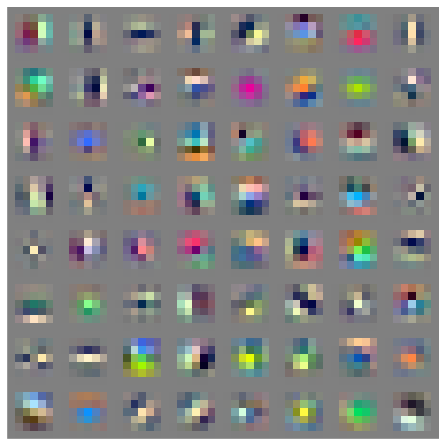

In [5]:
composite = np.zeros((7*8, 7*8, 3), dtype=np.uint8)
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        crop = np.squeeze(result[idx])[25:32, 25:32, :]
        crop = crop / np.max([-np.min(crop), np.max(crop)])
        crop = (crop * 127 + 128).astype(np.uint8)
        composite[(i*7):(i*7+7), (j*7):(j*7+7), :] = crop
        
plt.imshow(composite, interpolation='none')
# next 5 lines get rid of all white space when saving .png
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('plots/kernel_viz_1.png', bbox_inches='tight',
            pad_inches=0.0, dpi=64)
plt.show()